In [1]:
import os; os.chdir('..')
import numpy as np
from dataclasses import dataclass
import torch
from torch import nn
from torch.nn import functional as F
# from transformers import GPT2LMHeadModel
import matplotlib.pyplot as plt 
import time

# from tqdm import tqdm, trange
from tqdm.notebook import tqdm

from utils import *; from boring_utils.utils import *
from utils import add_to_class

from hf_gpt import (
    GPT, 
    GPTConfig,
)

from dataloader import (
    DataLoaderTiny
)

init_graph()
device = get_device()

def reset_model_weights(model):
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [2]:
assert str(device) == 'cuda', 'cuda needed for this notebook available'

In [3]:
model = GPT(GPTConfig())
model.to(device)
train_loader = DataLoaderTiny(B=4, T=32)

DataLoaderTiny -> len(self.tokens):
338025
calc: 1 epoch = ? batches
DataLoaderTiny -> len(self.tokens) // batch_size:
2640


In [4]:
# the default one in v3 + updated optm params
reset_model_weights(model)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)

pbar = tqdm(range(50), desc="Training")
for i in pbar:
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    logits, loss = model(x.to(device), y.to(device))
    loss.backward()
    optimizer.step()
    # tqdm.write(f"Step {i}, Loss: {loss.item():.4f}")
    pbar.set_description(f"Step {i}, Loss: {loss.item():.4f}")

Training:   0%|          | 0/50 [00:00<?, ?it/s]

# Improve Optimizer and Learning Rate

https://youtu.be/l8pRSuU81PU?t=8781 why not use dynamic batch size (to keep the total grad stable for optm)

In [5]:
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50

## lr Scheduler with Cosine Warmup

In [6]:
def get_lr(it, learning_rate, warmup_iters, lr_decay_iters, min_lr):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters

    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr

    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

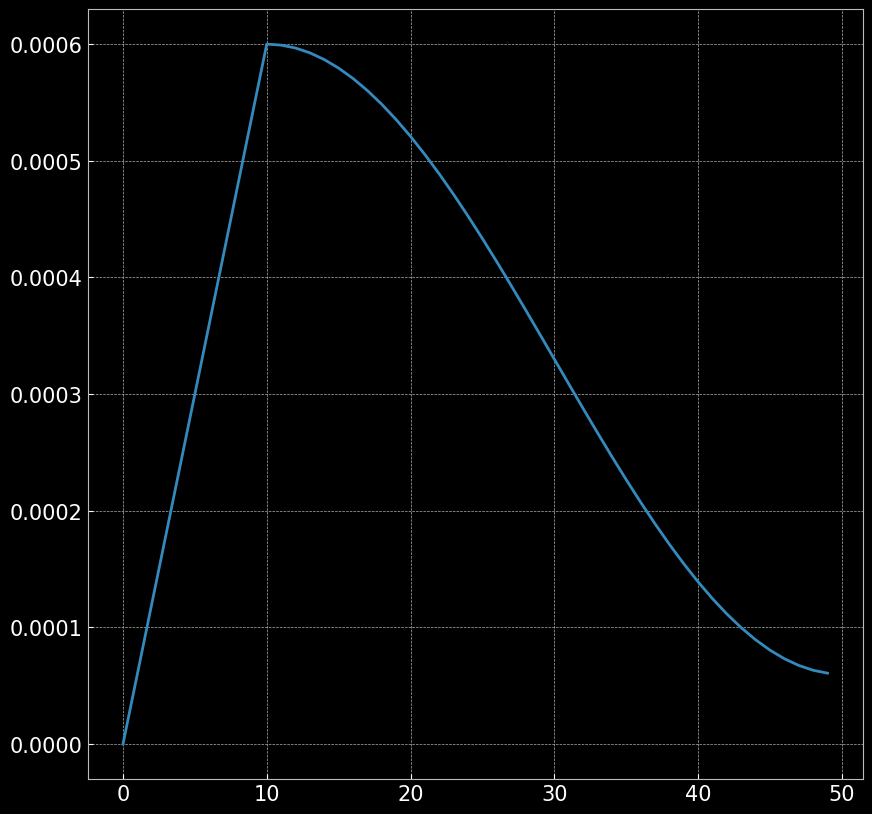

In [7]:
tmp_steps = 50
lr_list = [get_lr(i, max_lr, warmup_steps, tmp_steps, min_lr) for i in range(tmp_steps)]

plt.plot(lr_list) 

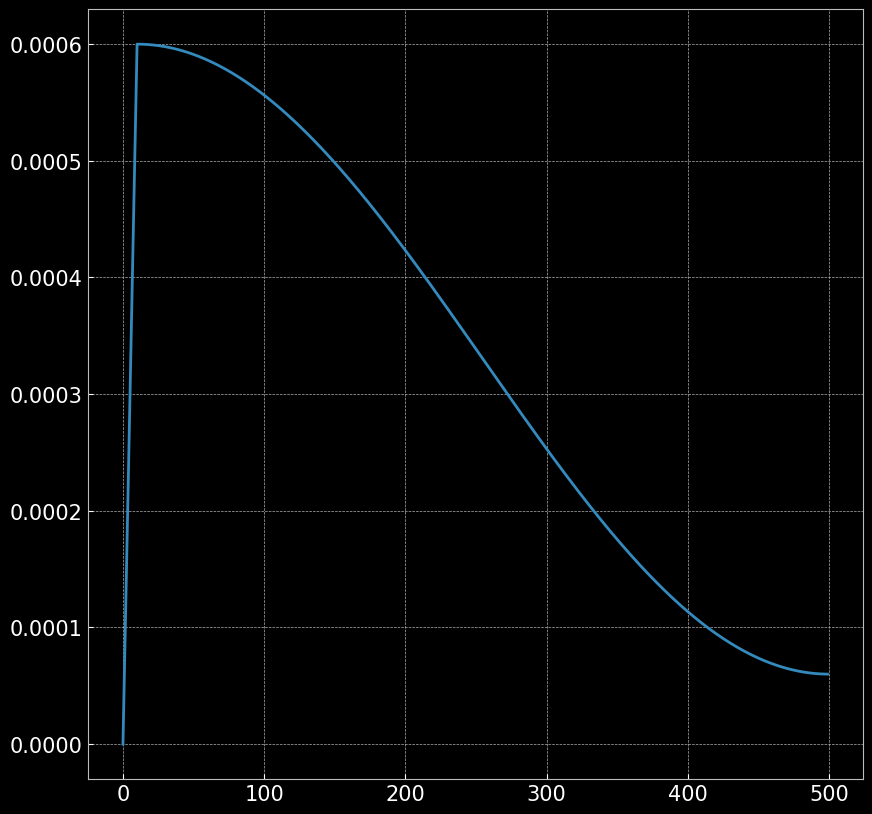

In [8]:
tmp_steps = 500
lr_list = [get_lr(i, max_lr, warmup_steps, tmp_steps, min_lr) for i in range(tmp_steps)]

plt.plot(lr_list) 

## GPT AdamW Fuse and Scheduler Class

In [9]:
@add_to_class(GPT)
def configure_optimizers(self, weight_decay, learning_rate, device_type):
    # start with all of the candidate parameters (that require grad)
    param_dict = {pn: p for pn, p in self.named_parameters()}
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]

    # preview the decay and nodecay layers
    tmp_decay_params = []
    tmp_nodecay_params = []
    for n, p in param_dict.items():
        if p.dim() >= 2 and len(tmp_decay_params) < 3:
            tmp_decay_params.append(n)
        elif p.dim() < 2 and len(tmp_nodecay_params) < 3:
            tmp_nodecay_params.append(n)
        if len(tmp_decay_params) >=3 and len(tmp_nodecay_params) >= 3:
            break
    cprint(tmp_decay_params, tmp_nodecay_params)
    
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]

    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    cprint(len(decay_params), num_decay_params)
    cprint(len(nodecay_params), num_nodecay_params)

    # Create AdamW optimizer and use the fused version if it is available
    # NOTE: fused is only available on CUDA devices, but is much faster
    fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and device_type == "cuda"
    cprint(f"using fused AdamW: {use_fused}")

    optimizer = torch.optim.AdamW(
        optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
    return optimizer

model = GPT(GPTConfig())
model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:
reset_model_weights(model)
optimizer = model.configure_optimizers(
    weight_decay=0.1, learning_rate=6e-4, device_type="cuda")

pbar = tqdm(range(max_steps), desc="Training")
for i in pbar:
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()

    # allow regions of script to run in mixed precision
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        logits, loss = model(x.to(device), y.to(device))

    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    lr = get_lr(i, max_lr, warmup_steps, max_steps, min_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    optimizer.step()
    torch.cuda.synchronize()

    t1 = time.time()
    dt = t1 - t0  # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T
    tokens_per_sec = tokens_processed / dt

    pbar.set_description(f"Step {i}, Loss: {loss.item():.4f}, LR: {lr:.1e}, Tokens/s: {tokens_per_sec:.2f}")

GPT -> tmp_decay_params:
['transformer.wte.weight',
 'transformer.wpe.weight',
 'transformer.h.0.attn.in_proj_weight']
GPT -> tmp_nodecay_params:
['transformer.h.0.ln_1.weight',
 'transformer.h.0.ln_1.bias',
 'transformer.h.0.ln_2.weight']
GPT -> f"{len(decay_params)}:
'50, 124,318,464'
GPT -> f"{len(nodecay_params)}:
'98, 121,344'
GPT -> f"using fused AdamW: {use_fused}":
'using fused AdamW: True'


Training:   0%|          | 0/50 [00:00<?, ?it/s]

# Grad Accumulation
https://youtu.be/l8pRSuU81PU?t=9249
- In the original GPT3 paper, the 124M's batch size B=0.5M, we don't have a large enought GPU for that.
- Plus the batch size is correlated with other hyper parameters.

In [11]:
total_batch_size = 524288  # 2 ** 19, ~0.5M in number of tokens
B = 16  # micro batch size
T = 1024  # seq len
assert total_batch_size % (B * T) == 0
grad_accum_steps = total_batch_size // (B * T)  # in this case, 32
est_time_per_batch = dt * grad_accum_steps  # dt is from the previous step
cprint(grad_accum_steps, est_time_per_batch)

<module> -> grad_accum_steps:
32
<module> -> est_time_per_batch:
2.43511962890625


## A Demo about Grad Accum

In [12]:
# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)

x = torch.randn(4, 16)
y = torch.randn(4, 1)

In [13]:
# the loss objective here is (due to readuction='mean')
# L = 1/4 * [
#            (y[0] - yhat[0])**2 +
#            (y[1] - yhat[1])**2 +
#            (y[2] - yhat[2])**2 +
#            (y[3] - yhat[3])**2
#           ]
# NOTE: 1/4!

net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()

print(net[0].weight.grad.view(-1)[:10])

tensor([-0.1876, -0.0548,  0.0244,  0.0627,  0.0301, -0.0168, -0.0751, -0.1609,
        -0.1997, -0.0341])


In [14]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = 1/4(y[0] - yhat[0])**2
# L1 = 1/4(y[1] - yhat[1])**2
# L2 = 1/4(y[2] - yhat[2])**2
# L3 = 1/4(y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost

net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4  # <-- have to add back the "normalizer"!
    loss.backward()

print(net[0].weight.grad.view(-1)[:10])

tensor([-0.1876, -0.0548,  0.0244,  0.0627,  0.0301, -0.0168, -0.0751, -0.1609,
        -0.1997, -0.0341])


## Grad Accum in GPT2

In [15]:
reset_model_weights(model)
optimizer = model.configure_optimizers(
    weight_decay=0.1, learning_rate=6e-4, device_type="cuda")

pbar = tqdm(range(max_steps), desc="Training")
for i in pbar:
    t0 = time.time()
    optimizer.zero_grad()

    # grad accumulation
    loss_accum = 0.0
    # grad_accum_steps = total_batch_size // (B * T)
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()

        # allow regions of script to run in mixed precision
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits, loss = model(x.to(device), y.to(device))

        # we have to scale the loss to account for gradient accumulation
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()

    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    lr = get_lr(i, max_lr, warmup_steps, max_steps, min_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    optimizer.step()
    torch.cuda.synchronize()

    t1 = time.time()
    dt = t1 - t0  # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T
    tokens_per_sec = tokens_processed / dt

    pbar.set_description(f"Step {i}, Loss: {loss.item():.4f}, LR: {lr:.1e}, Tokens/s: {tokens_per_sec:.2f}")

GPT -> tmp_decay_params:
['transformer.wte.weight',
 'transformer.wpe.weight',
 'transformer.h.0.attn.in_proj_weight']
GPT -> tmp_nodecay_params:
['transformer.h.0.ln_1.weight',
 'transformer.h.0.ln_1.bias',
 'transformer.h.0.ln_2.weight']
GPT -> f"{len(decay_params)}:
'50, 124,318,464'
GPT -> f"{len(nodecay_params)}:
'98, 121,344'
GPT -> f"using fused AdamW: {use_fused}":
'using fused AdamW: True'


Training:   0%|          | 0/50 [00:00<?, ?it/s]